In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
NUM_FOLDS = 10

# Loading

In [3]:
raw_df = pd.read_csv('123_results.csv')
raw_test_df = pd.read_csv('test_results.csv')
masks = pd.read_csv('masks.csv')

In [4]:
# collect columns
columns = list(raw_df.columns)
columns = \
    columns[:10] + \
    columns[11:13] + \
    columns[15:] + \
    ['pre_' + i for i in columns[13:15]] + \
    ['post_' + i for i in columns[13:15]] + \
    ['pre_final_accuracy'] + \
    ['post_final_accuracy'] + \
    ['t1_final_accuracy'] + \
    ['t2_final_accuracy'] + \
    ['final_accuracy'] + \
    ['t1_auc'] + \
    ['t2_auc'] + \
    ['auc'] + \
    ['unweighted_post_final_accuracy']

# collect rows
rows = list()
for i in range(len(raw_df)):
    if not i % 2:
        assert(raw_df.loc[i]['stage'] == 'post')
        post_row = list(raw_df.loc[i])
    else:
        assert(raw_df.loc[i]['stage'] == 'pre')
        pre_row = list(raw_df.loc[i])
        for j in range(10):
            assert(post_row[j] == pre_row[j])
        t1_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['1', '2']))]['count'].sum()
        t2_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['3']))]['count'].sum()
        row = \
            pre_row[:10] + \
            [np.array(post_row[11].split('_'))] + \
            [np.array(post_row[12].split('_'))] + \
            [post_row[15]] + \
            [float(i) for i in pre_row[13:15]] + \
            [float(i) for i in post_row[13:15]] + \
            [float((pre_row[13] * t1_size + pre_row[14] * t2_size) / (t1_size + t2_size))] + \
            [float((post_row[13] * t1_size + post_row[14] * t2_size) / (t1_size + t2_size))] + \
            [float((pre_row[13] + post_row[13]) / 2)] + \
            [float((pre_row[14] + post_row[14]) / 2)] + \
            [float(((pre_row[13] + post_row[13]) * t1_size / 2 + (pre_row[14] + post_row[14]) * t2_size / 2) / (t1_size + t2_size))] + \
            [np.sum([float(i) for i in post_row[11].split('_')])] + \
            [np.sum([float(i) for i in post_row[12].split('_')])] + \
            [(np.sum([float(i) for i in post_row[11].split('_')]) * t1_size + np.sum([float(i) for i in post_row[12].split('_')]) * t2_size) / (t1_size + t2_size)] + \
            [float((post_row[13] + post_row[14]) / 2)]
        rows.append(row)

# build new data frame
data = dict()
for i in range(len(columns)):
    data[columns[i]] = list()
    for j in range(len(rows)):
        data[columns[i]].append(rows[j][i])
df = pd.DataFrame(data=data)

In [5]:
df.head()

,seed,test_fold,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,...,post_t2_final_accuracy,pre_final_accuracy,post_final_accuracy,t1_final_accuracy,t2_final_accuracy,final_accuracy,t1_auc,t2_auc,auc,unweighted_post_final_accuracy
0,0,0,100,adam,0.1,None,0.75,0.9,None,10,...,0.0,0.31618,0.31618,0.468922,0.0,0.31618,9.37844,0.0,6.323606,0.234461
1,0,0,100,adam,0.1,None,0.75,0.9,None,20,...,0.0,0.31618,0.31618,0.468922,0.0,0.31618,18.75688,0.0,12.647212,0.234461
2,0,0,100,adam,0.1,None,0.75,0.9,None,40,...,0.0,0.31618,0.31618,0.468922,0.0,0.31618,37.51376,0.0,25.294424,0.234461
3,0,0,100,adam,0.1,None,0.75,0.9,None,5,...,0.0,0.31618,0.31618,0.468922,0.0,0.31618,4.68922,0.0,3.161803,0.234461
4,0,0,100,adam,0.1,None,0.75,0.9,None,80,...,0.0,0.31618,0.31618,0.468922,0.0,0.31618,75.02752,0.0,50.588848,0.234461


# Filtering

In [21]:
COLUMN = 'unweighted_post_final_accuracy'  # 'final_accuracy' 'auc' 'post_final_accuracy' 'unweighted_post_final_accuracy'
MAXIMIZE = True

In [22]:
adf = df.drop(columns=['test_fold', 'predictions'])
grouped_columns, agg_columns = list(adf.columns[:9]), list(adf.columns[9:])
grouped = adf.groupby(grouped_columns)
data = {k: list() for k in grouped_columns}
for column in agg_columns:
    data[column + '_mean'] = list()
    data[column + '_std'] = list()
    data[column + '_min'] = list()
    data[column + '_max'] = list()
for k, v in grouped:
    i = 0
    for v2 in k:
        data[adf.columns[i]].append(v2)
        i += 1
    while i < len(adf.columns):
        data[adf.columns[i] + '_mean'].append(np.mean(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_std'].append(np.std(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_min'].append(np.min(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_max'].append(np.max(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        i += 1
adf = pd.DataFrame(data=data)

In [23]:
fdf = pd.DataFrame(columns=adf.columns)
for seed in np.unique(adf['seed'].values):
    for epoch in np.unique(adf['epochs'].values):
        adam_df = adf[(adf['optimizer'] == 'adam') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
        rms_df = adf[(adf['optimizer'] == 'rms') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
        sgd_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.0'])]
        sgdmom_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.75', '0.9', '0.999'])]
        if MAXIMIZE:
            fdf = fdf.append(adam_df.loc[adam_df[COLUMN + '_mean'].idxmax()])
            fdf = fdf.append(rms_df.loc[rms_df[COLUMN + '_mean'].idxmax()])
            fdf = fdf.append(sgd_df.loc[sgd_df[COLUMN + '_mean'].idxmax()])
            fdf = fdf.append(sgdmom_df.loc[sgdmom_df[COLUMN + '_mean'].idxmax()])
        else:
            fdf = fdf.append(adam_df.loc[adam_df[COLUMN + '_mean'].idxmin()])
            fdf = fdf.append(rms_df.loc[rms_df[COLUMN + '_mean'].idxmin()])
            fdf = fdf.append(sgd_df.loc[sgd_df[COLUMN + '_mean'].idxmin()])
            fdf = fdf.append(sgdmom_df.loc[sgdmom_df[COLUMN + '_mean'].idxmin()])

In [24]:
fdf.head()

,seed,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,t1_accuracies_mean,...,t2_auc_min,t2_auc_max,auc_mean,auc_std,auc_min,auc_max,unweighted_post_final_accuracy_mean,unweighted_post_final_accuracy_std,unweighted_post_final_accuracy_min,unweighted_post_final_accuracy_max
40,0,100,adam,0.0001,None,0.999,0.99999,None,5,"[0.9822837999999999, 0.9879528000000001, 0.989...",...,0.822186,0.977162,6.913225,0.025046,6.847583,6.938462,0.907347,0.010183,0.886219,0.919380
190,0,100,rms,0.0001,None,None,None,0.99999,5,"[0.9942523, 0.9953546, 0.9951975000000001, 0.9...",...,5.000000,5.000000,5.275446,0.143239,4.996282,5.535562,0.519921,0.012945,0.500000,0.547207
560,0,50:50,sgd,0.0001,0.0,None,None,None,5,"[0.6817314, 0.7803129, 0.8407857, 0.8770057000...",...,3.228013,3.358892,6.344108,0.043692,6.268188,6.428344,0.750863,0.006171,0.741563,0.760616
245,0,100,sgd,0.0001,0.75,None,None,None,5,"[0.9140936999999999, 0.9477945999999999, 0.958...",...,4.840131,4.879283,6.622215,0.029031,6.576739,6.673567,0.653543,0.003832,0.648148,0.658392
106,0,100,adam,0.0100,None,0.9,0.9,None,10,"[0.9933856999999999, 0.9951185, 0.994725200000...",...,0.993475,10.000000,10.977272,1.045586,9.983003,13.413483,0.529575,0.074066,0.500000,0.750082


# Plotting

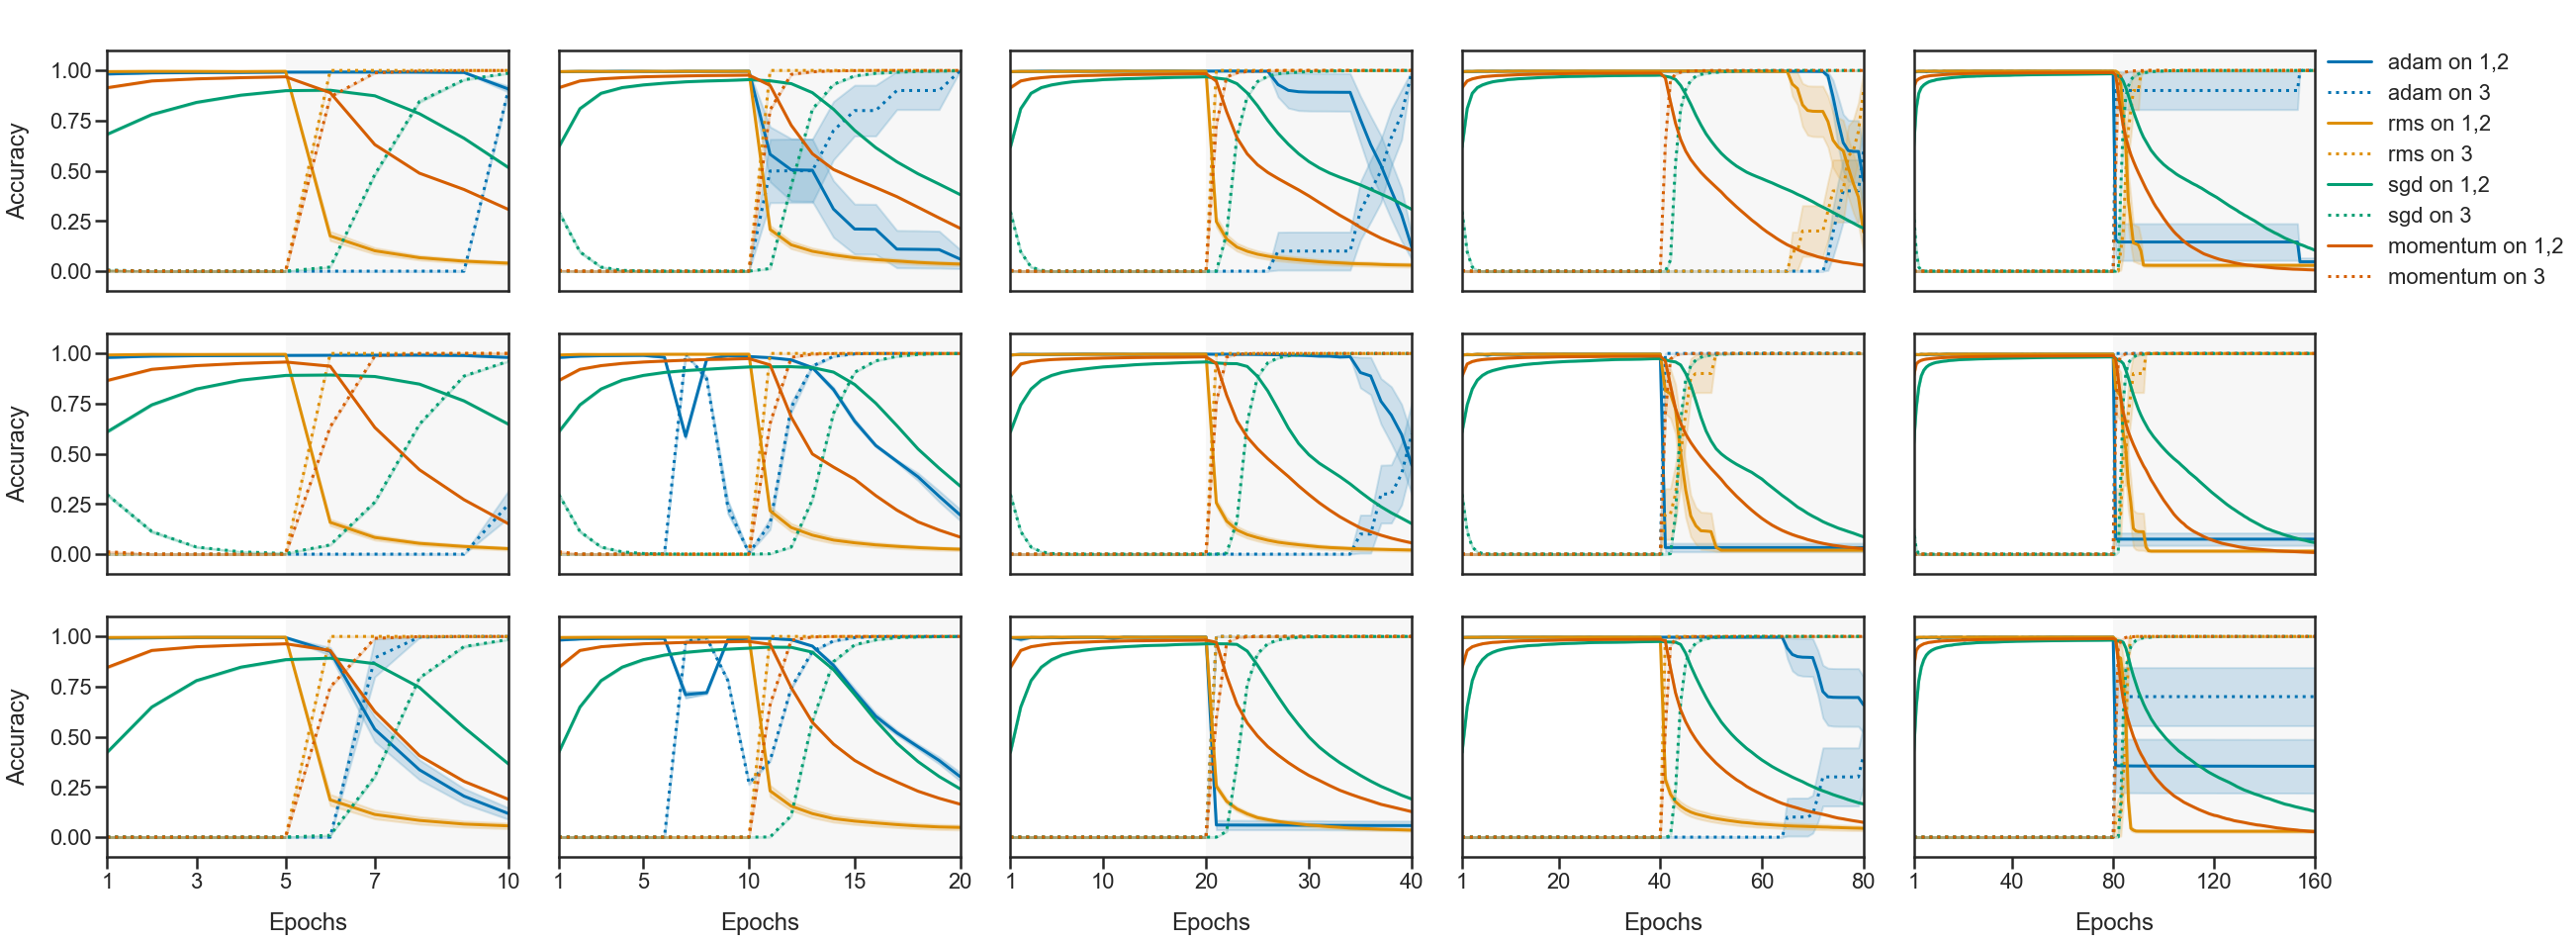

In [25]:
sns.set()
sns.set_style('ticks')
sns.set_context('poster')
fig, axmat = plt.subplots(len(np.unique(fdf['seed'].values)), len(np.unique(fdf['epochs'].values)), figsize=(8 * len(np.unique(fdf['epochs'].values)), 5 * len(np.unique(fdf['seed'].values))))
for i, seed in enumerate(np.unique(fdf['seed'].values)):
    sfdf = fdf[fdf['seed'] == seed]
    palette = sns.color_palette('colorblind', 4)
    labels = list()
    for j, epoch in enumerate(np.unique(sfdf['epochs'].values)):
        if j == 0:
            axmat[i, j].set_yticks(list(np.linspace(0, 1.0, 5, endpoint=True)))
            axmat[i, j].set_ylabel('Accuracy', labelpad=20)
        else:
            axmat[i, j].set_yticks([])
        if i == 2:
            if j == 0:
                axmat[i, j].set_xticks([1, 3, 5, 7, 10])
            else:
                axmat[i, j].set_xticks([1] + list(np.linspace(0, epoch * 2, 5, endpoint=True)))
            axmat[i, j].set_xlabel('Epochs', labelpad=20)
        else:
            axmat[i, j].set_xticks([])
        axmat[i, j].set_ylim(- 0.1, 1.1)
        axmat[i, j].set_xlim(1, epoch * 2)
        labels.clear()
        for k, (_, row) in enumerate(sfdf[sfdf['epochs'] == epoch].iterrows()):
            if row['optimizer'] == 'sgd':
                label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
            else:
                label = row['optimizer']
            labels.append(label + ' on 1,2')
            labels.append(label + ' on 3')
            x = np.arange(len(row['t1_accuracies_mean'])) + 1
            axmat[i, j].add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
            axmat[i, j].plot(
                x,
                row['t1_accuracies_mean'],
                linestyle='-',
                color=palette[k])
            axmat[i, j].fill_between(
                x,
                row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
                row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
                color=palette[k],
                alpha=0.25)
            axmat[i, j].plot(
                x,
                row['t2_accuracies_mean'],
                linestyle=':',
                color=palette[k])
            axmat[i, j].fill_between(
                x,
                row['t2_accuracies_mean'] - row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
                row['t2_accuracies_mean'] + row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
                color=palette[k],
                alpha=0.25)
legend = fig.legend(axmat[0, 0].get_lines(), labels, loc=(0.9, 0.685), ncol=1, frameon=False)
fig.subplots_adjust(wspace=0.125, hspace=0.175)
fig.savefig('{}.pdf'.format(COLUMN), bbox_extra_artists=(legend,), bbox_inches='tight')

In [26]:
# with PdfPages('{}.pdf'.format(COLUMN)) as pdf:
#     sns.set()
#     sns.set_style('ticks')
#     sns.set_context('talk')
#     for seed in np.unique(fdf['seed'].values):
#         sfdf = fdf[fdf['seed'] == seed]
#         fig, axarr = plt.subplots(len(np.unique(sfdf['epochs'].values)), 1, figsize=(15, 20))
#         palette = sns.color_palette('colorblind', 4)
#         labels = list()
#         axarr[0].set_title('SEED = {}'.format(seed), pad=20)
#         for i, epoch in enumerate(np.unique(sfdf['epochs'].values)):
#             axarr[i].set_ylabel('Accuracy', labelpad=20)
#             if i == 4: axarr[i].set_xlabel('Epochs', labelpad=20)
#             axarr[i].set_xticks(np.linspace(0, epoch * 2, 5, endpoint=True))
#             axarr[i].set_xlim(1, epoch * 2)
#             axarr[i].set_ylim(- 0.1, 1.1)
#             labels.clear()
#             for j, (_, row) in enumerate(sfdf[sfdf['epochs'] == epoch].iterrows()):
#                 if row['optimizer'] == 'sgd':
#                     label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
#                 else:
#                     label = row['optimizer']
#                 labels.append(label + ' on 1,2')
#                 labels.append(label + ' on 3')
#                 x = np.arange(len(row['t1_accuracies_mean'])) + 1
#                 axarr[i].add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
#                 axarr[i].plot(x,
#                               row['t1_accuracies_mean'],
#                               linestyle='-',
#                               color=palette[j])
#                 axarr[i].fill_between(x,
# #                               row['t1_accuracies_min'],
# #                               row['t1_accuracies_max'],
#                               row['t1_accuracies_mean'] - row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               row['t1_accuracies_mean'] + row['t1_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               color=palette[j],
#                               alpha=0.25)
#                 axarr[i].plot(x,
#                               row['t2_accuracies_mean'],
#                               linestyle=':',
#                               color=palette[j])
#                 axarr[i].fill_between(x,
# #                               row['t2_accuracies_min'],
# #                               row['t2_accuracies_max'],
#                               row['t2_accuracies_mean'] - row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               row['t2_accuracies_mean'] + row['t2_accuracies_std'] / np.sqrt(NUM_FOLDS),
#                               color=palette[j],
#                               alpha=0.25)
#         legend = fig.legend(axarr[0].get_lines(), labels, loc=(0.81, 0.7875), ncol=1, frameon=False)
#         fig.subplots_adjust(right=0.8)
#         pdf.savefig(fig, bbox_extra_artists=(legend,), bbox_inches='tight')

# Analysis

In [28]:
tdf = fdf[fdf['epochs'].isin([20]) & fdf['seed'].isin([0])]
tdf[grouped_columns + ['final_accuracy_mean', 'auc_mean', 'post_final_accuracy_mean', 'unweighted_post_final_accuracy_mean']]

,seed,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,final_accuracy_mean,auc_mean,post_final_accuracy_mean,unweighted_post_final_accuracy_mean
47,0,100,adam,0.0010,None,0.75,0.9,None,20,0.538285,25.589254,0.404327,0.557783
192,0,100,rms,0.0001,None,None,None,0.99999,20,0.508733,20.878395,0.345649,0.514877
242,0,100,sgd,0.0001,0.0,None,None,None,20,0.592985,26.385312,0.532898,0.653701
247,0,100,sgd,0.0001,0.75,None,None,None,20,0.529287,24.780361,0.395200,0.551615
